**извлечение признаков из текста на естественном языке**

классификатор текстов

частотный анализ с очисткой стоп-слов (TF)

Евгений Борисов borisov.e@solarl.ru

## библиотеки

In [1]:
import numpy as np
import pandas as pd
import re

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [3]:
%matplotlib inline

In [4]:
pd.options.display.max_colwidth = 200  

## тексты

In [5]:
# загружаем тексты
data = pd.read_pickle('../data/text/news.pkl.gz')
print('записей:',len(data))

записей: 3196


In [6]:
data.sample(2)

,text,tag
205,"В Лос-Анджелесе объявлены номинации на премию ""Энни"" Номинации на\nамериканскую премию ""Энни"", присуждаемую за лучшие работы в области\nмультипликации, объявлены в Лос-Анджелесе. Безусловным лидер...",culture
901,"Второй день противостояния в Котовке. Девять часов минчане защищали сквер от ""Зеленстроя""\n\nопубликовано: 7 декабря 2016 в 12:18\n\nобновлено: 7 декабря 2016 в 17:09\n\nЕлена Толкачева / Фото: Ев...",realty


---

In [8]:
from nltk import download as nltk_download
nltk_download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mechanoid/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords


stopwords = set(nltk_stopwords.words('russian') )

In [10]:
# from Stemmer import Stemmer

In [11]:
%%time 

data['text_clean'] = data['text'].str.lower() # приведение в lowercase

# замена символов-разделителей (-,_) на пробел
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'\W', ' ', s))
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'_', ' ', s))

# замена цифр
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'\b\d+\b', ' ', s))

# делим строки на слова (токенизация)
data['text_clean'] = data['text_clean'].apply(lambda t: [ w.strip() for w in t.split() if len(w.strip())>2 ] )

# удаление лишних слов 
data['text_clean'] = data['text_clean'].apply(lambda t:[w for w in t if w not in stopwords])

# стемминг, выделение основы слова
# data['text_clean'] = data['text_clean'].apply( lambda t: Stemmer('russian').stemWords(t) )
data['text_clean'] = data['text_clean'].apply(lambda t:[ SnowballStemmer('russian').stem(w) for w in t if w])


CPU times: user 59.6 s, sys: 167 ms, total: 59.7 s
Wall time: 1min


In [12]:
data['text_clean'] = data['text_clean'].apply(lambda t:' '.join(t))

In [13]:
data[['text_clean']].sample(2)

,text_clean
226,алл пугачев нижн тагил представител администрац город нижн таг опроверга информац певиц алл пугачев пережива развод скрыва город
2888,сет опубликова нов виде будущ модел мотив kia эксперт увер нов представител модел представл след год евген штол трудн разобра элемент интерьер автомобил отмет машин берет секунд перв виде нов авто...


##  CountVectorizer + TF

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
tf = TfidfVectorizer(use_idf=True,norm='l2')
# tf = TfidfVectorizer(use_idf=False,norm='l2')

tf.fit( data['text_clean'] )

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [16]:
len(tf.vocabulary_)

34887

## формируем датасеты

In [17]:
X = tf.transform( data['text_clean'] )
X.shape

(3196, 34887)

In [18]:
labels = { t:i for i,t in enumerate(sorted(set(data['tag']))) }
labels

{'auto': 0,
 'culture': 1,
 'economics': 2,
 'health': 3,
 'incident': 4,
 'politics': 5,
 'realty': 6,
 'reclama': 7,
 'science': 8,
 'social': 9,
 'sport': 10,
 'tech': 11,
 'woman': 12}

In [19]:
y = data['tag'].map(labels).values
y

array([5, 1, 1, ..., 8, 5, 9])

---

In [20]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.9, random_state=326 )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((319, 34887), (319,), (2877, 34887), (2877,))

## обучаем

In [21]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge',max_iter=1000, tol=0.19)
clf.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.19,
              validation_fraction=0.1, verbose=0, warm_start=False)

## тестируем

In [22]:
o = clf.predict(X_train)

In [23]:
accuracy_score(y_train,o)

1.0

---

In [24]:
o = clf.predict(X_test)

In [25]:
accuracy_score(y_test,o)

0.7698992005561348

In [26]:
print( classification_report(y_test,o) )

              precision    recall  f1-score   support

           0       0.92      0.72      0.81       227
           1       0.76      0.81      0.78       319
           2       0.77      0.77      0.77       240
           3       0.48      0.19      0.27        86
           4       0.92      0.80      0.85       396
           5       0.82      0.87      0.84       542
           6       0.37      0.59      0.45        58
           7       0.54      0.37      0.43        41
           8       0.64      0.97      0.77       200
           9       0.36      0.37      0.36       133
          10       0.92      0.97      0.94       340
          11       0.75      0.70      0.72       262
          12       0.00      0.00      0.00        33

    accuracy                           0.77      2877
   macro avg       0.63      0.62      0.62      2877
weighted avg       0.77      0.77      0.76      2877



---

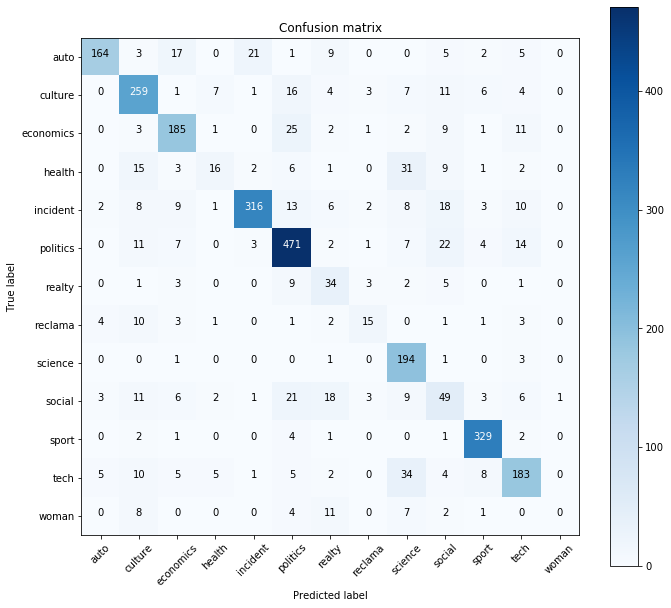

In [27]:
from matplotlib import pyplot as plt
import itertools

classes = sorted(labels.keys())
cm = confusion_matrix(y_test,o)
tick_marks = np.arange(len(classes))

plt.figure(figsize=(10,9))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.title('Confusion matrix')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

plt.show()

---

In [28]:
o = clf.predict(X)

In [29]:
labels_inv = { labels[k]:k for k in labels }
# labels_inv

In [30]:
i = np.random.randint(len(data))
print('tag:',data.iloc[i,1])
print('predict:',labels_inv[o[i]])
print('- - - - - - - - - - - - - - - - - - \n')
print(data.iloc[i,0])

tag: incident
predict: incident
- - - - - - - - - - - - - - - - - - 

Советским следственным отделом Следственного комитета по Бурятии предъявлено обвинение мастеру аварийной службы "Улан-Удэнского энергетического комплекса" филиала ОАО <object>ТГК-14</object> в нарушении правил безопасности при ведении строительных и иных работ, повлекших по неосторожности смерть человека (ч. 2 ст. 216 УК России)

Напомним, речь идет о ЧП, случившемся в октябре прошлого года, когда на одном из участков улан-удэнской теплотрассы рабочего завалило песком. Потерпевший умер на месте происшествия.

По данным следствия, происшествие было связано с нарушениями правил безопасности, допущенными мастером аварийной службы. Свою вину в совершении инкриминируемого деяния обвиняемый не признал. В отношении него избрана мера пресечения в виде подписки о невыезде.

В ближайшее время обвиняемому и его защитнику будут представлены материалы уголовного дела для ознакомления, после чего дело будет направлено прокурору дл